# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
import scipy.stats
import datetime as dt
import warnings

warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Embedding, LeakyReLU, concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

# Data Preparation

In [2]:
lens_total = pd.read_csv('lens_total.csv', index_col=0)
label = pd.read_csv('label.csv', index_col=0)
scaler = MinMaxScaler()
lens_total_scaled = scaler.fit_transform(lens_total)

In [4]:
lens_1_pi = lens_total['pi']
lens_1_pi = pd.DataFrame(lens_1_pi)
lens_1_pi_scaled = scaler.fit_transform(lens_1_pi)

# Model

In [11]:
def define_generator(numerical):    
  #Inputting noise  from latent space
    noise = Input(shape = (100,))
    hidden_1 = Dense(8, kernel_initializer = "he_uniform")(noise)    
    hidden_1 = LeakyReLU(0.2)(hidden_1)    
    hidden_1 = BatchNormalization(momentum = 0.8)(hidden_1) 
    hidden_2 = Dense(16, kernel_initializer = "he_uniform")(hidden_1)    
    hidden_2 = LeakyReLU(0.2)(hidden_2)    
    hidden_2 = BatchNormalization(momentum = 0.8)(hidden_2)    

    #Branch 12 for generating numerical data 
    branch_12 = Dense(64, kernel_initializer = "he_uniform")(hidden_2)    
    branch_12 = LeakyReLU(0.2)(branch_12)    
    branch_12 = BatchNormalization(momentum=0.8)(branch_12)    
    branch_12 = Dense(128, kernel_initializer = "he_uniform")(branch_12)    
    branch_12 = LeakyReLU(0.2)(branch_12)    
    branch_12 = BatchNormalization(momentum=0.8)(branch_12)    
    
    #Output Layer12 
    branch_12_output = Dense(numerical, activation = "sigmoid")(branch_12)    

    return Model(inputs = noise, outputs = branch_12_output)    

    
generator = define_generator(lens_1_pi_scaled.shape[1])  
generator.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 808       
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 8)                 0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 8)                 32        
_________________________________________________________________
dense_23 (Dense)             (None, 16)                144       
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 16)                0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 16)              

In [12]:
def define_discriminator(inputs_n):  
    #Input from generator
    d_input = Input(shape = (inputs_n,))    
    d = Dense(128, kernel_initializer="he_uniform")(d_input)  
    d = LeakyReLU(0.2)(d)  
    d = Dense(64, kernel_initializer="he_uniform")(d)  
    d = LeakyReLU(0.2)(d)  
    d = Dense(32, kernel_initializer="he_uniform")(d)  
    d = LeakyReLU(0.2)(d)  
    d = Dense(16, kernel_initializer="he_uniform")(d)  
    d = LeakyReLU(0.2)(d)  
    d = Dense(8, kernel_initializer="he_uniform")(d)  
    d = LeakyReLU(0.2)(d)  

    #Output Layer
    d_output = Dense(1, activation = "sigmoid")(d)  

    #compile and return model
    model = Model(inputs = d_input, outputs = d_output)  
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr=0.0002, beta_1=0.5), metrics = ["accuracy"])  
    return model  


inputs_n = lens_1_pi_scaled.shape[1]  
discriminator = define_discriminator(inputs_n)  
discriminator.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_27 (Dense)             (None, 128)               256       
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 32)              

Epoch: 50 [Discriminator loss: 0.699841] [Generator loss: 0.664072]
Epoch: 100 [Discriminator loss: 0.703670] [Generator loss: 0.702861]
Epoch: 150 [Discriminator loss: 0.703043] [Generator loss: 0.729792]
Epoch: 200 [Discriminator loss: 0.697108] [Generator loss: 0.722380]
Epoch: 250 [Discriminator loss: 0.701990] [Generator loss: 0.700970]
Epoch: 300 [Discriminator loss: 0.697859] [Generator loss: 0.684415]
Epoch: 350 [Discriminator loss: 0.699826] [Generator loss: 0.719519]
Epoch: 400 [Discriminator loss: 0.699004] [Generator loss: 0.699901]
Epoch: 450 [Discriminator loss: 0.702691] [Generator loss: 0.713877]
Epoch: 500 [Discriminator loss: 0.700971] [Generator loss: 0.694641]
Epoch: 550 [Discriminator loss: 0.703916] [Generator loss: 0.729549]
Epoch: 600 [Discriminator loss: 0.699180] [Generator loss: 0.720327]
Epoch: 650 [Discriminator loss: 0.700061] [Generator loss: 0.706504]
Epoch: 700 [Discriminator loss: 0.700606] [Generator loss: 0.705698]
Epoch: 750 [Discriminator loss: 0.7

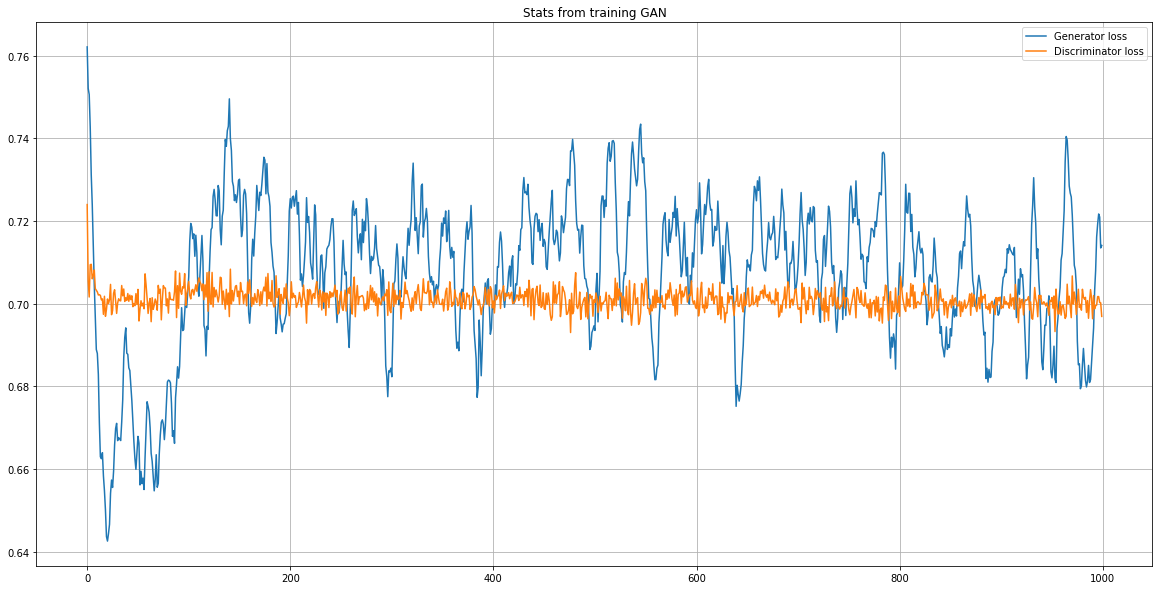

In [13]:
def define_complete_gan(generator, discriminator):  
    discriminator.trainable = False  
    gan_output = discriminator(generator.output)  
    
    #Initialize gan
    model = Model(inputs = generator.input, outputs = gan_output)  

    #Model Compilation
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr=0.0002, beta_1=0.5))  
    return model  

completegan = define_complete_gan(generator, discriminator)  

def gan_train(gan, generator, discriminator, numerical, latent_dim, n_epochs, n_batch, n_eval):  
    #Upddte Discriminator with half batch size
    half_batch = int(n_batch / 2)  
    discriminator_loss = []  
    generator_loss = []  
    #generate class labels for fake and real
    valid = np.ones((half_batch, 1))  
    y_gan = np.ones((n_batch, 1))  
    fake = np.zeros((half_batch, 1))  

    #training
    for i in range(n_epochs):  
        #select random batch from real categorical and numerical data
        idx = np.random.randint(0, numerical.shape[0], half_batch)
        numerical_real = lens_1_pi_scaled[idx]  

        #concatenate categorical and numerical data for the discriminator
        real_data = numerical_real
  
        #generate fake samples from the noise
        noise = np.random.normal(0, 1, (half_batch, latent_dim))  
        fake_data = generator.predict(noise)  
     
        #train the discriminator and return losses and acc
        d_loss_real, da_real = discriminator.train_on_batch(real_data, valid)  
        d_loss_fake, da_fake = discriminator.train_on_batch(fake_data, fake)  
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)  
        discriminator_loss.append(d_loss)  
       
        #generate noise for generator input and train the generator (to have the discriminator label samples as valid)
        noise = np.random.normal(0, 1, (n_batch, latent_dim))  
        g_loss = gan.train_on_batch(noise, y_gan)  
        generator_loss.append(g_loss)  

        #evaluate progress
        if (i+1) % n_eval == 0:  
            print ("Epoch: %d [Discriminator loss: %f] [Generator loss: %f]" % (i + 1, d_loss, g_loss))  
            
    plt.figure(figsize = (20, 10))  
    plt.plot(generator_loss, label = "Generator loss")  
    plt.plot(discriminator_loss, label = "Discriminator loss")     
    plt.title("Stats from training GAN")  
    plt.grid()  
    plt.legend()  

latent_dim = 100
gan_train(completegan, generator, discriminator, lens_1_pi_scaled, latent_dim, n_epochs = 1000, n_batch = 63, n_eval = 50)